In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab import drive

In [3]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive')
!unzip dataset.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/glacier/5964.jpg  
  inflating: /content/dataset/glacier/5972.jpg  
  inflating: /content/dataset/glacier/5978.jpg  
  inflating: /content/dataset/glacier/5980.jpg  
  inflating: /content/dataset/glacier/5985.jpg  
  inflating: /content/dataset/glacier/5994.jpg  
  inflating: /content/dataset/glacier/60.jpg  
  inflating: /content/dataset/glacier/6002.jpg  
  inflating: /content/dataset/glacier/6007.jpg  
  inflating: /content/dataset/glacier/602.jpg  
  inflating: /content/dataset/glacier/6023.jpg  
  inflating: /content/dataset/glacier/6029.jpg  
  inflating: /content/dataset/glacier/6030.jpg  
  inflating: /content/dataset/glacier/6043.jpg  
  inflating: /content/dataset/glacier/6044.jpg  
  inflating: /content/dataset/glacier/6048.jpg  
  inflating: /content/dataset/glacier/6055.jpg  
  inflating: /content/dataset/glacier/6076.jpg  
  inflating: /content/dataset/glacier/6081.jpg  
  inflating: /content

In [4]:
IMAGE_SIZE = (150, 150)
NUM_CLASSES = 6
DATASET_PATH = '/content/dataset'

In [5]:
categories = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

In [6]:
def load_images_from_folder(base_path):
    images, labels = [], []
    for label, category in enumerate(categories):
        folder_path = os.path.join(base_path, category)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, IMAGE_SIZE)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

In [8]:
def extract_features(model, X):
    features = model.predict(X)
    features = features.reshape(features.shape[0], -1)
    return features

In [16]:
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, target_names=categories.keys())
    cm = confusion_matrix(y_val, y_pred)
    try:
      roc_auc = roc_auc_score(y_val, model.predict_proba(X_val), multi_class='ovr')
    except AttributeError:
      roc_auc = "N/A (model does not support predict_proba)"
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", cm)
    print(f"ROC AUC Score: {roc_auc:.4f}")

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                  xticklabels=categories.keys(), yticklabels=categories.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [10]:
X, y = load_images_from_folder(DATASET_PATH)
print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]}")

Loaded 14034 images with shape (150, 150, 3)


In [11]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
X_features = extract_features(base_model, X)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
439/439 ━━━━━━━━━━━━━━━━━━━━ 3393s 8s/step


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_features, y, test_size=0.1, stratify=y, random_state=42)

Bayesian Classifier:
Accuracy: 0.6880
Classification Report:
               precision    recall  f1-score   support

   buildings       0.76      0.87      0.81       219
      forest       0.98      0.86      0.92       227
     glacier       0.53      0.40      0.45       241
    mountain       0.50      0.81      0.62       251
         sea       0.68      0.43      0.53       228
      street       0.81      0.76      0.78       238

    accuracy                           0.69      1404
   macro avg       0.71      0.69      0.69      1404
weighted avg       0.71      0.69      0.68      1404

Confusion Matrix:
 [[191   1   1   2   2  22]
 [  7 195   3   3   8  11]
 [  2   1  96 124  15   3]
 [  1   0  28 204  17   1]
 [  1   0  52  70  98   7]
 [ 48   1   2   1   4 182]]
ROC AUC Score: 0.8308


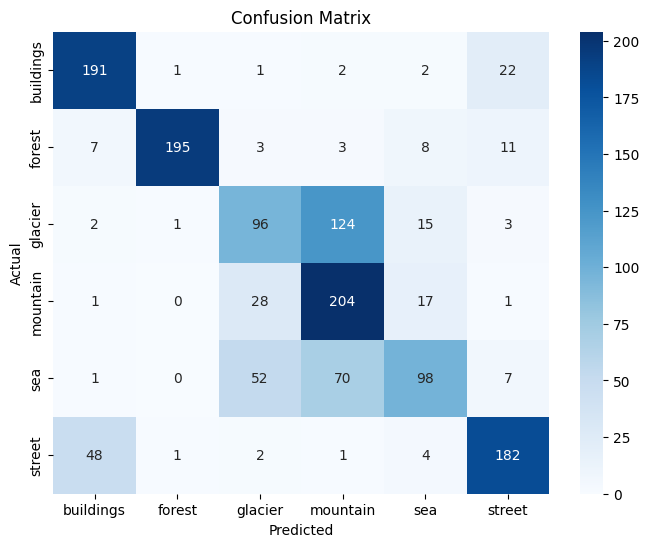

In [13]:
bayes_classifier = GaussianNB()
bayes_classifier.fit(X_train, y_train)
print("Bayesian Classifier:")
evaluate_model(bayes_classifier, X_val, y_val)

Decision Tree Classifier:
Accuracy: 0.7913
Classification Report:
               precision    recall  f1-score   support

   buildings       0.79      0.79      0.79       219
      forest       0.92      0.91      0.92       227
     glacier       0.68      0.67      0.67       241
    mountain       0.72      0.76      0.74       251
         sea       0.83      0.81      0.82       228
      street       0.82      0.81      0.81       238

    accuracy                           0.79      1404
   macro avg       0.79      0.79      0.79      1404
weighted avg       0.79      0.79      0.79      1404

Confusion Matrix:
 [[174   4   5   3   4  29]
 [  3 207   6   0   4   7]
 [  2   6 161  52  20   0]
 [  1   1  46 192   8   3]
 [  5   3  16  16 185   3]
 [ 34   4   3   3   2 192]]
ROC AUC Score: 0.8759


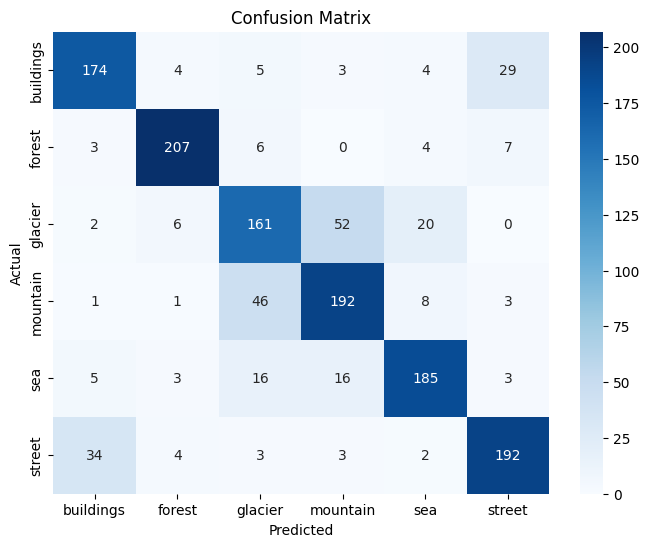

In [14]:
tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(X_train, y_train)
print("Decision Tree Classifier:")
evaluate_model(tree_classifier, X_val, y_val)

SVM Classifier:
Accuracy: 0.8967
Classification Report:
               precision    recall  f1-score   support

   buildings       0.89      0.94      0.91       219
      forest       0.99      0.98      0.98       227
     glacier       0.79      0.81      0.80       241
    mountain       0.83      0.84      0.84       251
         sea       0.96      0.92      0.94       228
      street       0.95      0.90      0.92       238

    accuracy                           0.90      1404
   macro avg       0.90      0.90      0.90      1404
weighted avg       0.90      0.90      0.90      1404

Confusion Matrix:
 [[206   0   0   0   1  12]
 [  0 223   1   2   1   0]
 [  1   2 195  37   6   0]
 [  0   0  38 212   1   0]
 [  2   1  13   3 209   0]
 [ 23   0   1   0   0 214]]
ROC AUC Score: 0.9888


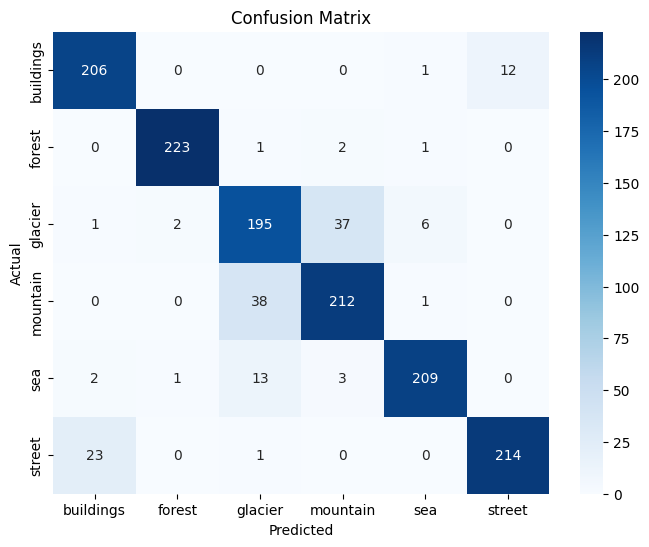

In [15]:
svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(X_train, y_train)
print("SVM Classifier:")
evaluate_model(svm_classifier, X_val, y_val)